In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

data = pd.read_csv('../../data/events.csv', low_memory=False)

data['fecha'] = pd.to_datetime(data['timestamp'], errors='coerce')
data['mes'] = data['fecha'].dt.month
data['dayofyear'] = data['fecha'].dt.dayofyear

sns.set(style="white", context="talk")

### Quiero analizar el formato de los SKU porque me está volviendo loco

In [5]:
data['sku_real'] = data.sku.apply(lambda x: str(x))
data['caso'] = data.sku_real.apply(lambda x: len(x.split('.')))
data['sku_category'] = data.sku_real.apply(lambda x: x.split('.')[0])

In [6]:
generic_listing = data[data['event'] == 'generic listing']
columna_pivote = 'person' # Elijo la columna por la cual voy a agrupar
lista = generic_listing['skus'].str.split(',', expand = True) # Rompo la lista de Skus y genero una lista para cada sku
lista[columna_pivote] = generic_listing[columna_pivote] # Guardo este resultado en el dataframe original

lista = lista.set_index(columna_pivote).stack().to_frame() # Convierno cada elemento de la lista de Skus en una unica fila
lista = lista.reset_index() 
lista.columns = [columna_pivote, 't', 'sku'] # Renombro las columnas
lista['caso'] = lista.sku.apply(lambda x: len(x.split('.')))
lista.caso.value_counts()


1    809052
Name: caso, dtype: int64

Los elementos del campo 'SKUS' vienen SIN el punto divisor, por lo que tendré que trabajar los skus individuales quitándole el punto.

### Diccionario de SKU => NOMBRE DE PRODUCTO

In [7]:
lista_productos = data[['sku_category', 'model']]
lista_productos = lista_productos.drop_duplicates('sku_category')
dict = lista_productos.set_index('sku_category').to_dict()

### Ya con todas estas consideraciones, intento encontrar una correlación entre los elementos visitados en la página principal y las conversiones POR USUARIO

In [9]:
generic_listing = data[data['event'] == 'generic listing']
columna_pivote = 'person' # Elijo la columna por la cual voy a agrupar
lista = generic_listing['skus'].str.split(',', expand = True) # Rompo la lista de Skus y genero una lista para cada sku
lista[columna_pivote] = generic_listing[columna_pivote] # Guardo este resultado en el dataframe original

lista = lista.set_index(columna_pivote).stack().to_frame() # Convierno cada elemento de la lista de Skus en una unica fila
lista = lista.reset_index() 
lista.columns = [columna_pivote, 't', 'sku_category'] # Renombro las columnas
lista = lista.dropna(subset = ['sku_category']) #Elimino los skus que son nulos
lista = lista.groupby(['sku_category']).size().to_frame('vistas')

lista.head()

,vistas
sku_category,
10001,113
10002,52
10014,117
10015,223
10016,337


In [11]:
checkout = data[data['event'] == 'checkout']
checkout = checkout.groupby(['sku_category']).size().to_frame('cantidad')

conversiones = data[data['event'] == 'conversion']
conversiones = conversiones.groupby(['sku_category']).size().to_frame('cantidad')


<Figure size 1440x720 with 0 Axes>

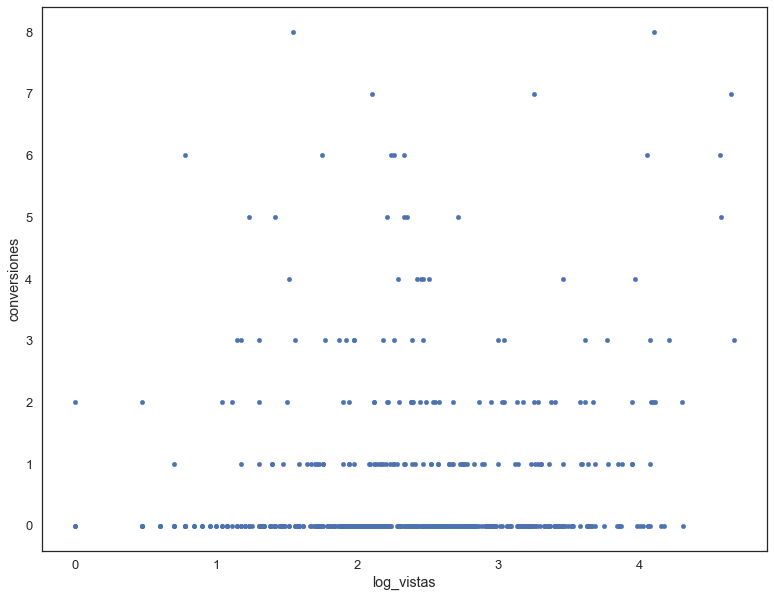

In [274]:
lista['log_vistas'] = np.log10(lista['vistas'])
plt.figure(figsize = (20, 10))
lista['conversiones'] = conversiones['cantidad']
lista['checkout'] = checkout['cantidad']
lista['conversiones'] = lista.conversiones.apply(lambda x: 0 if np.isnan(x) else x)
lista['checkout'] = lista.checkout.apply(lambda x: 0 if np.isnan(x) else x)


lista.plot.scatter(y = 'conversiones', x = 'log_vistas', figsize = (13, 10))

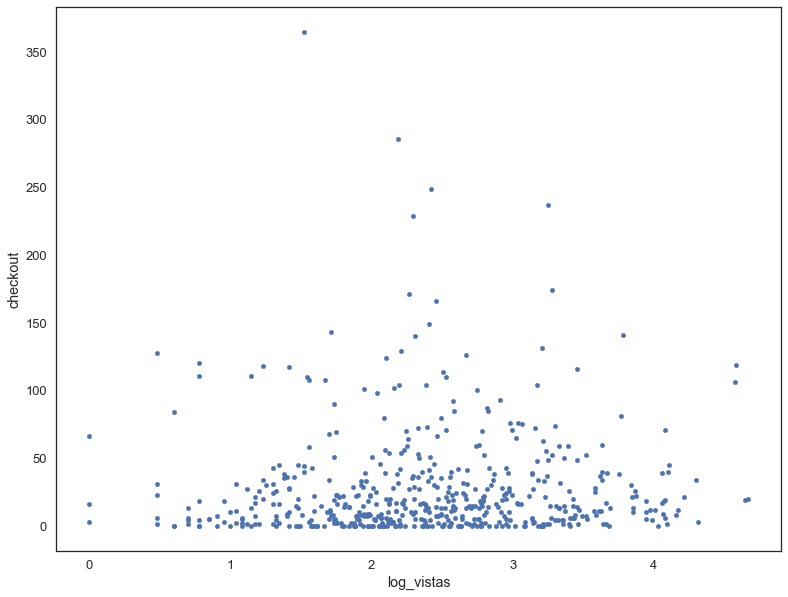

In [275]:
lista.plot.scatter(y = 'checkout', x = 'log_vistas', figsize = (13, 10))

### No parece haber ninguna correlación entre la cantidade de visitas a los productos en la página principal y su checkout/conversion

# Quiero ver si hay una relación entre los productos más convertidos y los más buscados

In [276]:
searched_products = data[data['event'] == 'searched products']
columna_pivote = 'person' # Elijo la columna por la cual voy a agrupar
lista = searched_products ['skus'].str.split(',', expand = True) # Rompo la lista de Skus y genero una lista para cada sku
lista[columna_pivote] = searched_products [columna_pivote] # Guardo este resultado en el dataframe original

lista = lista.set_index(columna_pivote).stack().to_frame() # Convierno cada elemento de la lista de Skus en una unica fila
lista = lista.reset_index() 
lista.columns = [columna_pivote, 't', 'sku_category'] # Renombro las columnas
lista = lista.dropna(subset = ['sku_category']) #Elimino los skus que son nulos
lista = lista.groupby(['sku_category']).size().to_frame('vistas')

lista.head()

,vistas
sku_category,
10001,36
10002,338
10014,108
10015,189
10016,628


Text(0,0.5,'Conversiones')

<Figure size 1440x720 with 0 Axes>

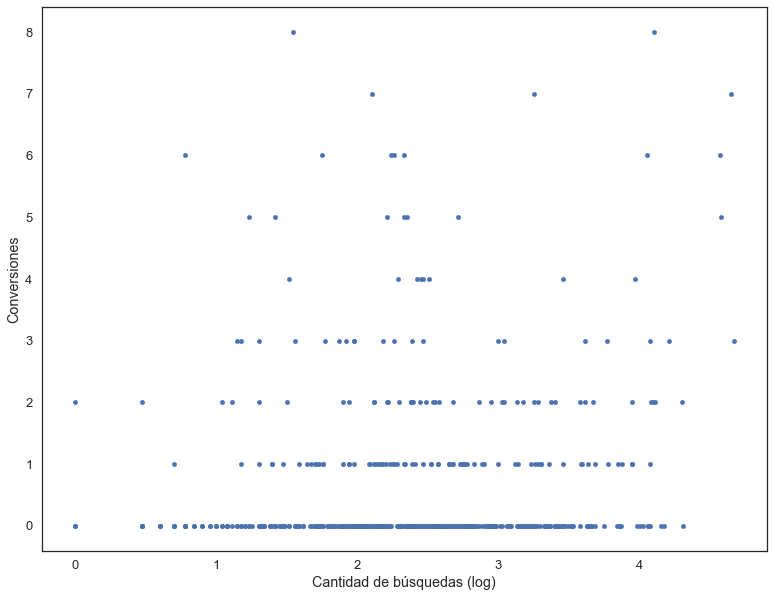

In [17]:
lista['log_vistas'] = np.log10(lista['vistas'])
lista['conversiones'] = conversiones['cantidad']
lista['checkout'] = checkout['cantidad']
lista['conversiones'] = lista.conversiones.apply(lambda x: 0 if np.isnan(x) else x)
lista['checkout'] = lista.checkout.apply(lambda x: 0 if np.isnan(x) else x)

plt.figure(figsize = (20, 10))
# graf = sns.regplot(data = lista, y = 'conversiones', x = 'log_vistas')
graf = lista.plot.scatter(y = 'conversiones', x = 'log_vistas', figsize = (13, 10))
graf.set_xlabel("Cantidad de búsquedas (log)")
graf.set_ylabel("Conversiones")

Text(0,0.5,'Checkout')

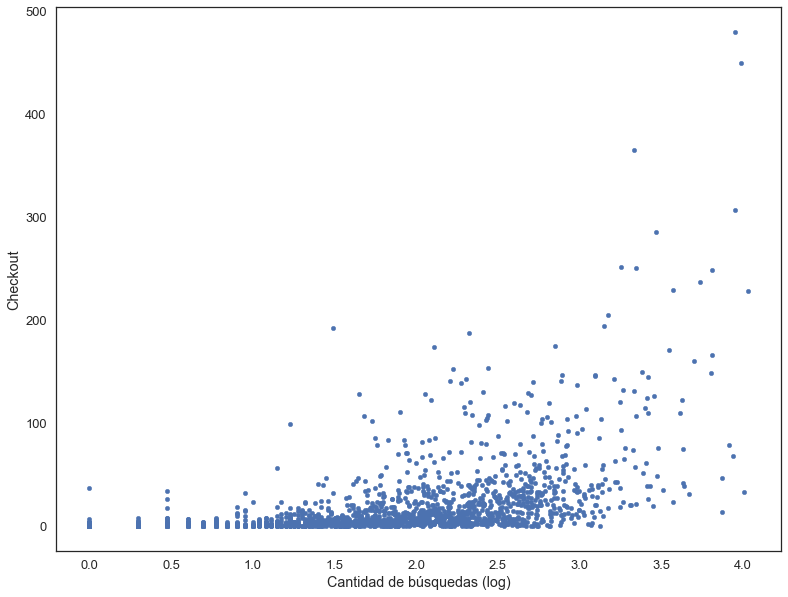

In [278]:
graf = lista.plot.scatter(y = 'checkout', x = 'log_vistas', figsize = (13, 10))
graf.set_xlabel("Cantidad de búsquedas (log)")
graf.set_ylabel("Checkout")

### ¿Podriamos afirmar que la cantidad de converisones y checkout crece proporcionalmente a la cantidad de busquedas?

# BRAND LISTING

In [279]:
brand_listing = data[data['event'] == 'brand listing']
columna_pivote = 'person' # Elijo la columna por la cual voy a agrupar
lista3 = brand_listing['skus'].str.split(',', expand = True) # Rompo la lista de Skus y genero una lista para cada sku
lista3[columna_pivote] = brand_listing[columna_pivote] # Guardo este resultado en el dataframe original

lista3 = lista3.set_index(columna_pivote).stack().to_frame() # Convierno cada elemento de la lista de Skus en una unica fila
lista3 = lista3.reset_index() 
lista3.columns = [columna_pivote, 't', 'sku_category'] # Renombro las columnas
lista3 = lista3.dropna(subset = ['sku_category']) #Elimino los skus que son nulos
lista3 = lista3.groupby(['sku_category']).size().to_frame('vistas')

lista3

,vistas
sku_category,
10001,27
10002,116
10014,187
10015,65
10016,535
10028,1262
10029,265
10030,361
10044,194


Text(0,0.5,'Conversiones')

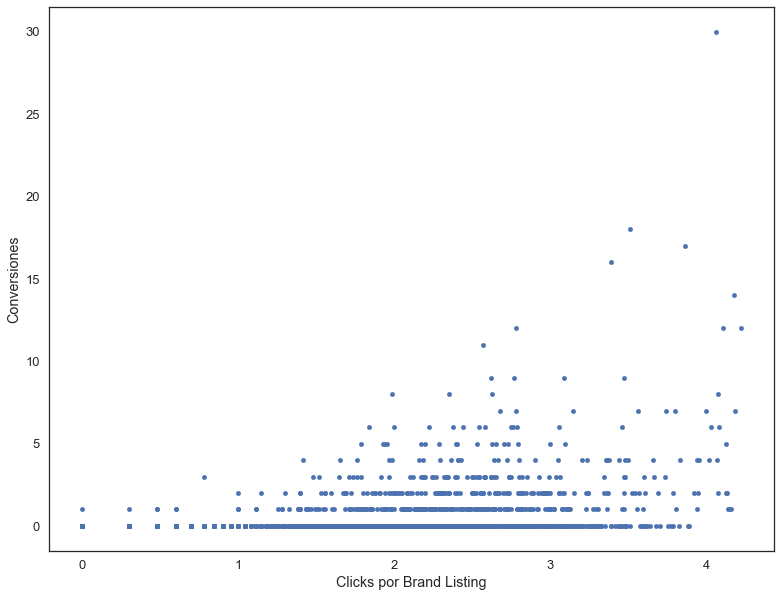

In [280]:
lista3['log_vistas'] = np.log10(lista3['vistas'])
lista3['conversiones'] = conversiones['cantidad']
lista3['conversiones'] = lista3.conversiones.apply(lambda x: 0 if np.isnan(x) else x)
graf = lista3.plot.scatter(y = 'conversiones', x = 'log_vistas', figsize = (13, 10))
graf.set_xlabel("Clicks por Brand Listing")
graf.set_ylabel("Conversiones")